In [1]:
library(tidyverse)
library(magrittr)
library(data.table)
library(okeanos.stooq)
library(lubridate)
library(scales)

── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked

In [2]:
# 1. download data from Stooq.com ----------------------------------------------
lStockIndexes <- list(
  "sp500" = "^SPX",
  "djia" = "^DJI",
  "nikkei" = "^NKX",
  "dax" = "^DAX",
  "ftse" = "^FTM"
)
dateMyEndDate <- lubridate::make_date(year = 2020, month = 12, day = 31)
dateMyStartDate <- lubridate::make_date(year = 2010, month = 1, day = 1)

lData <- okeanos.stooq::lGetDailyDataForTickersFromStooq(
  cTickers = unlist(lStockIndexes),
  dateStartDate = dateMyStartDate,
  dateEndDate = dateMyEndDate,
  bAddTickerToColnames = T
)
lData <- lapply(
  X = lData,
  FUN = function(x) {
    cColsToKeep <- c("Date", colnames(x)[grep(pattern = ".*Close$", x = colnames(x))])
    x[, ..cColsToKeep]
  }
)
dtData <- Reduce(f = function(dtL, dtR) {
  data.table::merge.data.table(x = dtL, y = dtR, by = "Date", all = T)
}, x = lData)

Fetching daily data for ticker: ^SPX

trying to fetch data from URL: https://stooq.com/q/d/l/?s=^spx&d1=20100101&d2=20201231&i=d

Fetching daily data for ticker: ^DJI

trying to fetch data from URL: https://stooq.com/q/d/l/?s=^dji&d1=20100101&d2=20201231&i=d

Fetching daily data for ticker: ^NKX

trying to fetch data from URL: https://stooq.com/q/d/l/?s=^nkx&d1=20100101&d2=20201231&i=d

Fetching daily data for ticker: ^DAX

trying to fetch data from URL: https://stooq.com/q/d/l/?s=^dax&d1=20100101&d2=20201231&i=d

Fetching daily data for ticker: ^FTM

trying to fetch data from URL: https://stooq.com/q/d/l/?s=^ftm&d1=20100101&d2=20201231&i=d



In [3]:
View(head(dtData))

Date,^SPX_Close,^DJI_Close,^NKX_Close,^DAX_Close,^FTM_Close
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-04,1132.99,10584.0,10654.79,6048.30,9510.11
2010-01-05,1136.52,10572.0,10681.83,6031.86,9557.09
2010-01-06,1137.14,10573.7,10731.45,6034.33,9589.53
2010-01-07,1141.69,10606.9,10681.66,6019.36,9630.38
2010-01-08,1144.98,10618.2,10798.32,6037.61,9689.05
2010-01-11,1146.98,10664.0,NA,6040.50,9726.44


In [4]:
# 2. parse the downloaded data -------------------------------------------------
cNewColnames <- sapply(
  X = str_split(string = colnames(dtData)[2:ncol(dtData)], pattern = "_"),
  FUN = function(x) { `[[`(x, 1) }
) %>% str_replace(pattern = "\\^", replacement = "")
data.table::setnames(x = dtData, old = colnames(dtData)[2:ncol(dtData)],
                     new = cNewColnames)
for (cIterCol in cNewColnames) {
  dtData[[cIterCol]] <- zoo::na.locf0(object = dtData[[cIterCol]], fromLast = F)
}

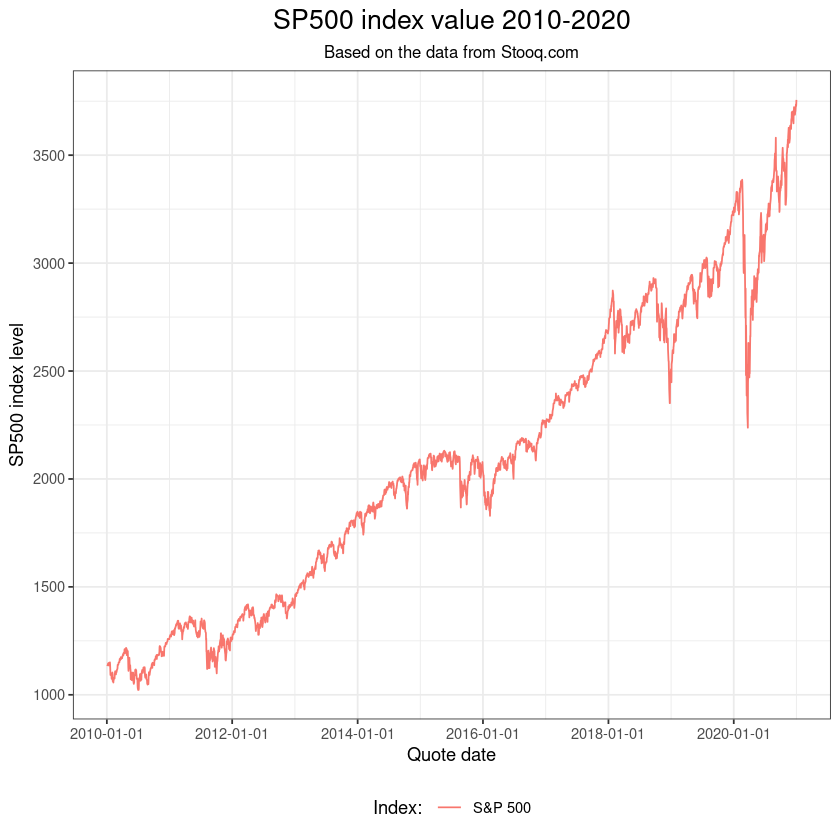

In [5]:
# 3. make a few line plots for practice ----------------------------------------
# 3.1. SPX only
dtSpxData <- dtData[, list(Date, SPX)]
dtSpxData[, index_name := "SPX"]
plotSpx <- ggplot(data = dtSpxData, mapping = aes(x = Date, y = SPX, color = index_name)) +
  geom_line() +
  theme_bw() + 
  ggtitle(
    label = "SP500 index value 2010-2020", 
    subtitle = "Based on the data from Stooq.com"
  ) +
  xlab(label = "Quote date") +
  ylab(label = "SP500 index level") + 
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 10),
    legend.position = "bottom"
  ) + 
  scale_color_discrete(
    name = "Index: ",
    labels = "S&P 500"
  ) + 
  scale_y_continuous(
    breaks = seq(1000, 4000, 500)
  ) + 
  scale_x_date(
    breaks = make_date(year = seq(2010, 2020, 2), month = 1, day = 1)
  )
plotSpx

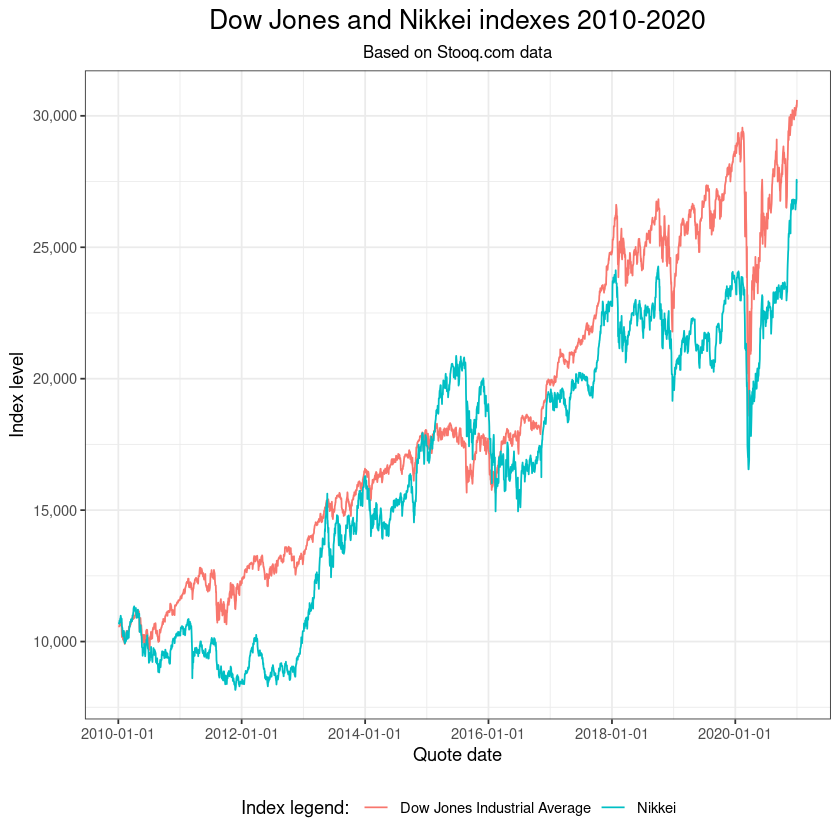

In [6]:
# 3.2. DJIA and NKX in one chart
dtTwoIndexesData <- dtData[, list(Date, DJI, NKX)]
dtTwoIndexesLongData <- data.table::melt.data.table(
  data = dtTwoIndexesData,
  id.vars = "Date",
  measure.vars = c("DJI", "NKX"),
  variable.name = "which_index",
  value.name = "index_level"
)
plotTwoIndexes <- ggplot(
  data = dtTwoIndexesLongData,
  mapping = aes(
    x = Date,
    y = index_level,
    color = which_index
  )
) +
  geom_line() + 
  theme_bw() +
  xlab(label = "Quote date") +
  ylab(label = "Index level") + 
  ggtitle(
    label = "Dow Jones and Nikkei indexes 2010-2020", 
    subtitle = "Based on Stooq.com data"
  ) + 
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 10),
    legend.position = "bottom"
  ) +
  scale_x_date(
    breaks = make_date(year = seq(2010, 2020, 2), month = 1, day = 1)
  ) + 
  scale_color_discrete(
    name = "Index legend: ",
    labels = c("Dow Jones Industrial Average", "Nikkei")
  ) +
  scale_y_continuous(
    labels = scales::comma
  )
plotTwoIndexes

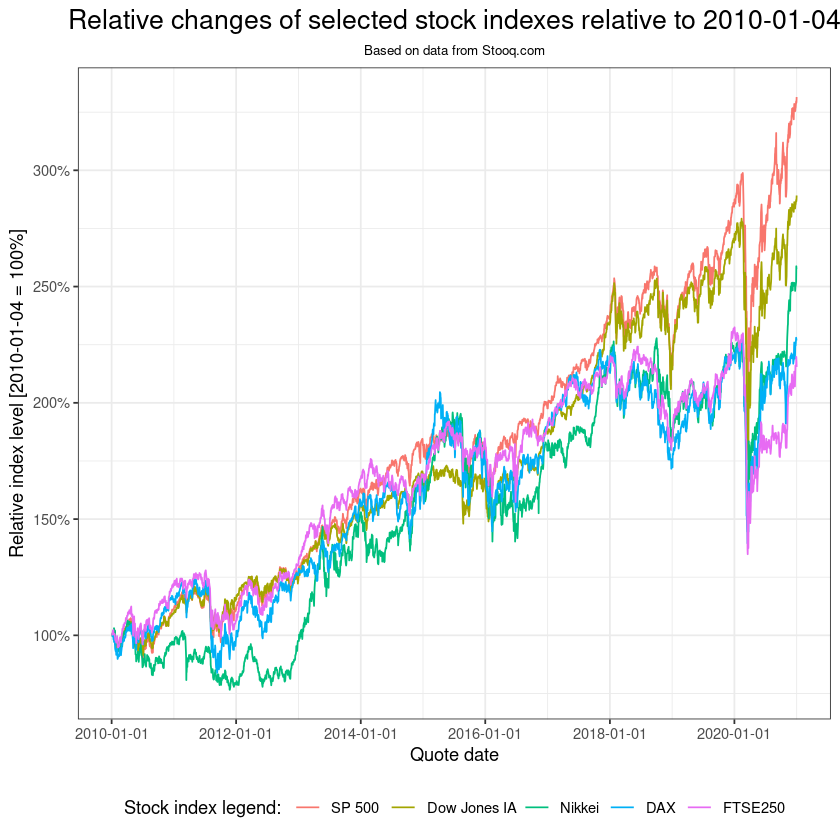

In [7]:
# 3.3. plot of level relative to 2010-01-04
dtIndexData <- data.table::copy(x = dtData)
dtTemp <- dtIndexData[, ..cNewColnames]
dtIndexData[, (cNewColnames) := lapply(
  X = dtTemp,
  FUN = function(x) {
    unlist(x) / unlist(x)[[1]]
  }
)]
dtMeltedIndexData <- data.table::melt.data.table(
  data = dtIndexData,
  id.vars = "Date",
  measure.vars = colnames(dtIndexData)[2:6],
  variable.name = "which_index",
  value.name = "index_value"
)

plotRelativeGrowth <- ggplot(
  data = dtMeltedIndexData,
  mapping = aes(
    x = Date,
    y = index_value,
    color = which_index
  )
) + 
  geom_line() +
  theme_bw() + 
  xlab(label = "Quote date") +
  ylab(label = "Relative index level [2010-01-04 = 100%]") +
  ggtitle(
    label = "Relative changes of selected stock indexes relative to 2010-01-04", 
    subtitle = "Based on data from Stooq.com"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 8),
    legend.position = "bottom"
  ) + 
  scale_x_date(
    breaks = make_date(year = seq(2010, 2020, 2), month = 1, day = 1)
  ) + 
  scale_y_continuous(
    labels = scales::percent
  ) + 
  scale_color_discrete(
    name = "Stock index legend: ",
    labels = c("SP 500", "Dow Jones IA", "Nikkei", "DAX", "FTSE250")
  )
plotRelativeGrowth
